# 6 Visualise laballed data and remove artefacts

Code that let us overlay each frame of video with outputs from the models. And create time series plots. 

In [1]:
import os
import cv2
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import utils
import display

In [2]:
videos_in = r"..\LookitLaughter.test"
metadata_file = "_LookitLaughter.xlsx"
data_out = r"..\data\1_interim"

#a couple of files for testing
VIDEO_FILE  = os.path.join(videos_in, "2UWdXP.joke1.rep2.take1.Peekaboo.mp4")
VIDEO_FILE2 = os.path.join(videos_in, "2UWdXP.joke2.rep1.take1.NomNomNom.mp4")

testset = [VIDEO_FILE, VIDEO_FILE2] 

In [3]:
processedvideos = utils.getprocessedvideos(data_out)
processedvideos.head()

found existing processedvideos.xlsx


,Unnamed: 0,Index,VideoID,ChildID,JokeType,JokeNum,JokeRep,JokeTake,HowFunny,LaughYesNo,...,Audio.file,Faces.when,Faces.file,LastError,Speech.file,Speech.when,Objects.file,Objects.when,Understand.file,Understand.when
0,0,0,2UWdXP.joke1.rep2.take1.Peekaboo.mp4,2UWdXP,Peekaboo,1,2,1,Slightly funny,No,...,..\data\1_interim\\2UWdXP.joke1.rep2.take1.Pee...,2023-09-24 07:52:41,..\data\1_interim\2UWdXP.joke1.rep2.take1.Peek...,NaN,..\data\1_interim\2UWdXP.joke1.rep2.take1.Peek...,2023-09-20 16:58:38,NaN,NaN,NaN,NaN
1,1,1,2UWdXP.joke1.rep3.take1.Peekaboo.mp4,2UWdXP,Peekaboo,1,3,1,Slightly funny,No,...,..\data\1_interim\\2UWdXP.joke1.rep3.take1.Pee...,2023-09-24 07:54:38,..\data\1_interim\2UWdXP.joke1.rep3.take1.Peek...,NaN,..\data\1_interim\2UWdXP.joke1.rep3.take1.Peek...,2023-09-20 16:58:39,NaN,NaN,NaN,NaN
2,2,2,2UWdXP.joke2.rep1.take1.NomNomNom.mp4,2UWdXP,NomNomNom,2,1,1,Funny,No,...,..\data\1_interim\\2UWdXP.joke2.rep1.take1.Nom...,2023-09-24 07:55:58,..\data\1_interim\2UWdXP.joke2.rep1.take1.NomN...,NaN,..\data\1_interim\2UWdXP.joke2.rep1.take1.NomN...,2023-09-20 16:58:40,NaN,NaN,NaN,NaN
3,3,3,2UWdXP.joke2.rep2.take1.NomNomNom.mp4,2UWdXP,NomNomNom,2,2,1,Slightly funny,No,...,..\data\1_interim\\2UWdXP.joke2.rep2.take1.Nom...,2023-09-24 07:56:57,..\data\1_interim\2UWdXP.joke2.rep2.take1.NomN...,NaN,..\data\1_interim\2UWdXP.joke2.rep2.take1.NomN...,2023-09-20 16:58:40,NaN,NaN,NaN,NaN
4,4,4,2UWdXP.joke2.rep3.take1.NomNomNom.mp4,2UWdXP,NomNomNom,2,3,1,Slightly funny,No,...,..\data\1_interim\\2UWdXP.joke2.rep3.take1.Nom...,2023-09-24 07:59:00,..\data\1_interim\2UWdXP.joke2.rep3.take1.NomN...,NaN,..\data\1_interim\2UWdXP.joke2.rep3.take1.NomN...,2023-09-20 16:58:48,NaN,NaN,NaN,NaN


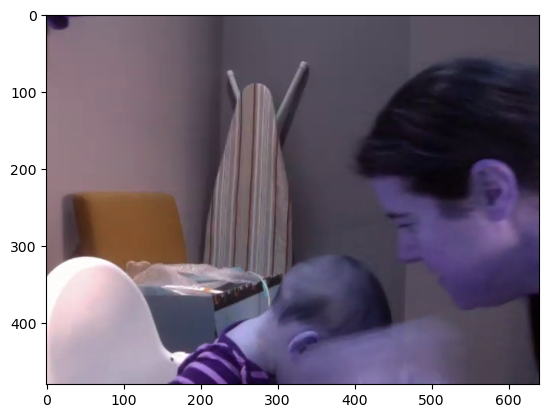

We have a keypoints file for this video


In [4]:
#let's grab a single frame from the video

framenum = 4
video = cv2.VideoCapture(VIDEO_FILE)
video.set(cv2.CAP_PROP_POS_FRAMES, framenum)
ret, frame = video.read()

if ret:
    plt.imshow(frame)
    plt.show()

#look in processed videos to see if we have a keypoints file for this video
videoname = os.path.basename(VIDEO_FILE)
videodata = processedvideos[processedvideos['VideoID'] == videoname]
if videodata.shape[0] > 0:
    print("We have a keypoints file for this video")
    kptsfile = videodata['Keypoints.file'].values[0]
    #Load the keypoints file
    kpts = pd.read_csv(kptsfile)
    kpts.head()

video.release()

In [5]:
print(f"kptsfile: {kptsfile}")

kpts.iloc[3]

kptsfile: ..\data\1_interim\2UWdXP.joke1.rep2.take1.Peekaboo.csv


Unnamed: 0            3.000000
frame                 3.000000
person                0.000000
bboxcent.x          517.692200
bboxcent.y          268.861542
bbox.width          244.291595
bbox.height         422.276947
bbox.c                0.519463
nose.x              451.206238
nose.y              312.775391
nose.c                0.950903
left_eye.x          467.204437
left_eye.y          267.338623
left_eye.c            0.988065
right_eye.x         454.171204
right_eye.y         275.966919
right_eye.c           0.235540
left_ear.x          572.157776
left_ear.y          238.928513
left_ear.c            0.967395
right_ear.x         519.890564
right_ear.y         258.796753
right_ear.c           0.002977
left_shoulder.x     583.715942
left_shoulder.y     429.665161
left_shoulder.c       0.451757
right_shoulder.x    599.972229
right_shoulder.y    384.976929
right_shoulder.c      0.284799
left_elbow.x        433.458069
left_elbow.y        480.000000
left_elbow.c          0.029976
right_el

In [12]:
framekpts = kpts[kpts['frame'] == 3]


framekpts.shape

bbox  = framekpts.iloc[0][1:5].values
xycs = np.reshape(framekpts.iloc[0][8:].values, (17,3))

print(xycs)

[[     451.21      312.78      0.9509]
 [      467.2      267.34     0.98807]
 [     454.17      275.97     0.23554]
 [     572.16      238.93      0.9674]
 [     519.89       258.8   0.0029772]
 [     583.72      429.67     0.45176]
 [     599.97      384.98      0.2848]
 [     433.46         480    0.029976]
 [     497.98      403.49    0.021228]
 [     466.16      420.83     0.13011]
 [     449.01      421.17    0.098306]
 [     566.99         480   0.0020262]
 [        594      478.11   0.0027338]
 [     482.82      473.45   0.0029867]
 [     540.93      431.98   0.0039066]
 [     500.93      427.21   0.0029871]
 [     483.23      387.56   0.0041373]]


In [14]:
frame = display.drawOneFrame(frame, xycs)


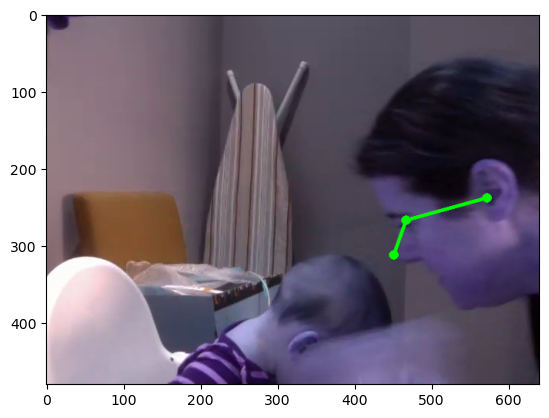

In [15]:
plt.imshow(frame)
plt.show()